In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D,concatenate,DepthwiseConv2D,BatchNormalization,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
import keras.backend as K
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.metrics import Metric
from keras.optimizers import Adam

In [2]:
train_dir = r'F:\MV\Dataset\cars_tanks\train'
test_dir = r'F:\MV\Dataset\cars_tanks\test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1108 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense



def inception_block(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)

    conv5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool])
    return inception_block

def inception_net(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception blocks
    x = inception_block(x, filters=[64, 128, 128, 32, 32, 32])
    x = inception_block(x, filters=[128, 192, 192, 64, 64, 64])
            # Attention mechanism
    x = squeeze_excitation_block(x)

    # MaxPooling and Fully Connected layers
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=x)

    return model




In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, GlobalAveragePooling2D, Reshape, Multiply

class SelfAttention(Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        self.Wq = Dense(self.filters)
        self.Wk = Dense(self.filters)
        self.Wv = Dense(self.filters)
        self.Ws = Dense(1, activation='sigmoid')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = self.Wq(inputs)
        k = self.Wk(inputs)
        v = self.Wv(inputs)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        attended_values = tf.matmul(attention_weights, v)

        # Apply spatial attention weights
        avg_pool = GlobalAveragePooling2D()(attended_values)
        avg_pool = Reshape((1, 1, self.filters))(avg_pool)
        spatial_weights = self.Ws(avg_pool)
        attended_inputs = Multiply()([attended_values, spatial_weights])

        return attended_inputs


In [6]:
def depthwise_resnet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Depthwise separable convolution block 1
    x = DepthwiseConv2D(3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(64, (1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)


    # Depthwise separable convolution block 2
    x = DepthwiseConv2D(3, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(128, (1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SelfAttention(64)(x)

    # Depthwise separable convolution block 3
    x = DepthwiseConv2D(3, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(256, (1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Assuming you have a custom Attention layer
    x = SelfAttention(64)(x)


    output = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(output)

    model = Model(inputs=input_layer, outputs=output)

    return model


from tensorflow.keras.callbacks import EarlyStopping

# Example usage
input_shape = (224, 224, 3)  # Adjust according to your image size and channels
num_classes = 2  # Adjust based on your classification task

model = depthwise_resnet(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_generator, epochs=350, validation_data=validation_generator,
             callbacks=[EarlyStopping(monitor='loss', patience=50, restore_best_weights = True)])

Epoch 1/350
35/35 [==============================] - 16s 338ms/step - loss: 0.6442 - accuracy: 0.6408 - val_loss: 0.6993 - val_accuracy: 0.4359
Epoch 2/350
35/35 [==============================] - 11s 310ms/step - loss: 0.5792 - accuracy: 0.7229 - val_loss: 0.7206 - val_accuracy: 0.4359
Epoch 3/350
35/35 [==============================] - 11s 312ms/step - loss: 0.5362 - accuracy: 0.7347 - val_loss: 0.7659 - val_accuracy: 0.4359
Epoch 4/350
35/35 [==============================] - 11s 317ms/step - loss: 0.5215 - accuracy: 0.7428 - val_loss: 0.8432 - val_accuracy: 0.4359
Epoch 5/350
35/35 [==============================] - 11s 316ms/step - loss: 0.5016 - accuracy: 0.7662 - val_loss: 0.9630 - val_accuracy: 0.4359
Epoch 6/350
35/35 [==============================] - 11s 312ms/step - loss: 0.4718 - accuracy: 0.7897 - val_loss: 1.1491 - val_accuracy: 0.4359
Epoch 7/350
35/35 [==============================] - 11s 319ms/step - loss: 0.4690 - accuracy: 0.7744 - val_loss: 1.3899 - val_accuracy:

In [7]:
# Print final training and validation accuracy and loss
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Final Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

7/7 [==============================] - 1s 74ms/step - loss: 0.6597 - accuracy: 0.7850
Final Training Loss: 0.0973, Accuracy: 0.9594
Final Validation Loss: 0.3099, Accuracy: 0.8667
Final Test Loss: 0.6597, Accuracy: 0.7850


In [8]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

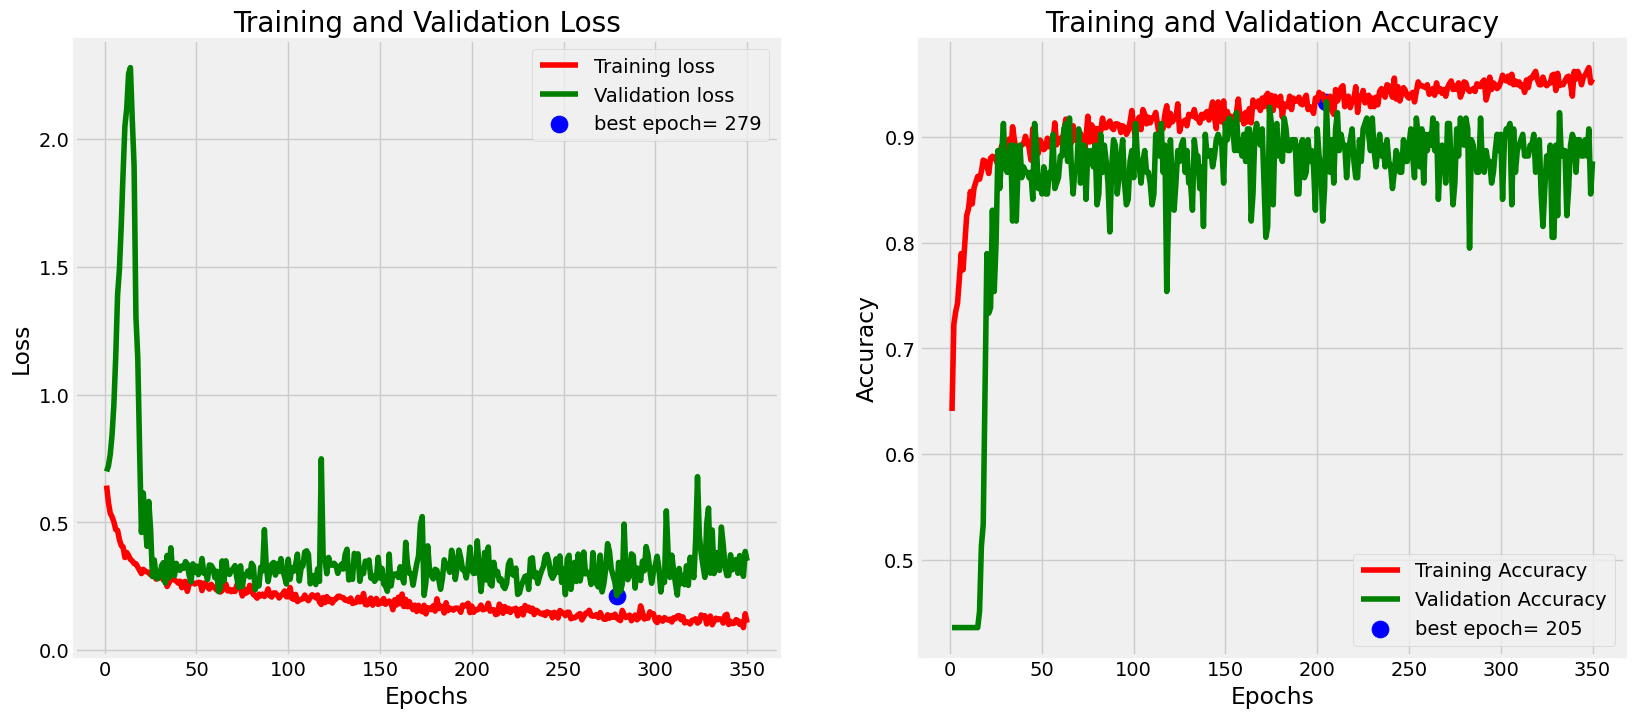

In [9]:
plot_training(history)

In [10]:
import tensorflow as tf
model.save_weights('saved_models\DResNetAttention_loss_weights.h5')

In [11]:
from keras import backend as K
import gc
del model
K.clear_session()
gc.collect()



9084